In [1]:
import os

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from tqdm import tqdm


/home/venom/miniconda3/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset


In [3]:
# # download data
root = "."
# SimpleOxfordPetDataset.download(root)  # init train, val, test sets



In [4]:
train_dataset = SimpleOxfordPetDataset(root, "train")
valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(root, "test")

# It is a good practice to check datasets don`t intersects with each other
assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(
    test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)


Train size: 3312
Valid size: 368
Test size: 3669


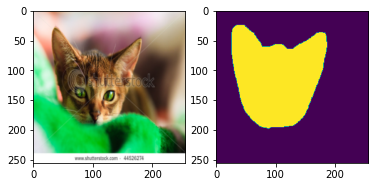

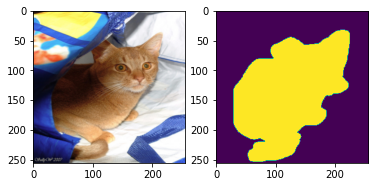

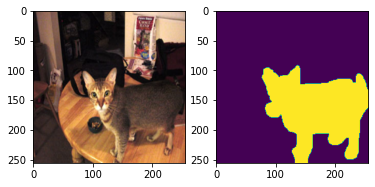

In [5]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()
     

In [6]:
class PetModel(nn.Module):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.std = torch.tensor(params["std"]).view(1, 3, 1, 1).cuda()
        self.mean = torch.tensor(params["mean"]).view(1, 3, 1, 1).cuda()
        self.loss_fn = smp.losses.DiceLoss(
            smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask


In [7]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    model.cuda()
    total_loss = 0.0

    with tqdm(total=len(train_loader), desc="Training") as progress_bar:
        for batch in train_loader:
            images = batch["image"]  # Move images to CUDA device
            images = images.cuda()
            masks = batch["mask"]
            masks = masks.cuda()

            optimizer.zero_grad()
            logits_mask = model(images)
            loss = criterion(logits_mask, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.update(1)

    return total_loss / len(train_loader)


def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad(), tqdm(total=len(val_loader), desc="Validation") as progress_bar:
        for batch in val_loader:
            images = batch["image"].cuda()
            masks = batch["mask"].cuda()

            logits_mask = model(images)
            loss = criterion(logits_mask, masks)

            total_loss += loss.item()
            progress_bar.update(1)

    return total_loss / len(val_loader)

def test(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad(), tqdm(total=len(test_loader), desc="Testing") as progress_bar:
        for batch in test_loader:
            images = batch["image"].cuda()
            masks = batch["mask"].cuda()

            logits_mask = model(images)
            loss = criterion(logits_mask, masks)

            total_loss += loss.item()
            progress_bar.update(1)

    return total_loss / len(test_loader)


In [8]:
arch = "FPN"
encoder_name = "resnet34"
in_channels = 3
out_classes = 1
model = PetModel(arch, encoder_name, in_channels, out_classes).cuda()
criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [9]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    val_loss = validate(model, valid_dataloader, criterion)
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Testing
test_loss = test(model, test_dataloader, criterion)
print(f"Test Loss: {test_loss:.4f}")

Validation: 100%|██████████| 23/23 [00:03<00:00,  6.87it/s]


Epoch 1/10 - Train Loss: 0.0956 - Val Loss: 0.0652


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.39it/s]


Epoch 2/10 - Train Loss: 0.0523 - Val Loss: 0.0542


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]


Epoch 3/10 - Train Loss: 0.0426 - Val Loss: 0.0502


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.05it/s]


Epoch 4/10 - Train Loss: 0.0381 - Val Loss: 0.0506


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.74it/s]


Epoch 5/10 - Train Loss: 0.0358 - Val Loss: 0.0489


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.47it/s]


Epoch 6/10 - Train Loss: 0.0330 - Val Loss: 0.0537


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.69it/s]


Epoch 7/10 - Train Loss: 0.0365 - Val Loss: 0.0513


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.94it/s]


Epoch 8/10 - Train Loss: 0.0314 - Val Loss: 0.0479


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.06it/s]


Epoch 9/10 - Train Loss: 0.0280 - Val Loss: 0.0465


Validation: 100%|██████████| 23/23 [00:03<00:00,  5.88it/s]


Epoch 10/10 - Train Loss: 0.0261 - Val Loss: 0.0453


Testing: 100%|██████████| 230/230 [00:21<00:00, 10.64it/s]

Test Loss: 0.0440


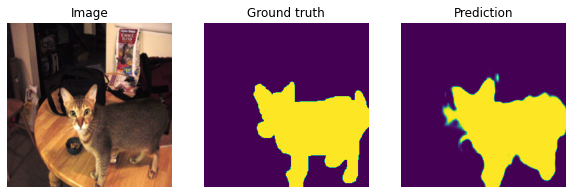

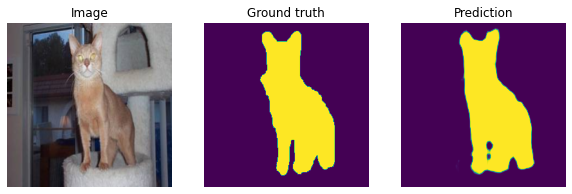

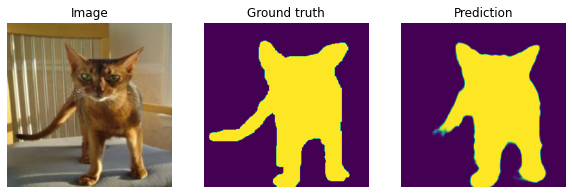

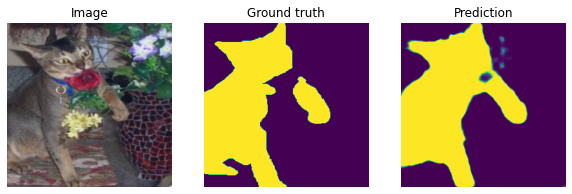

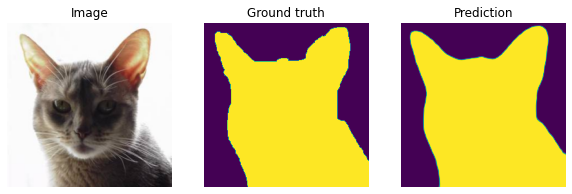

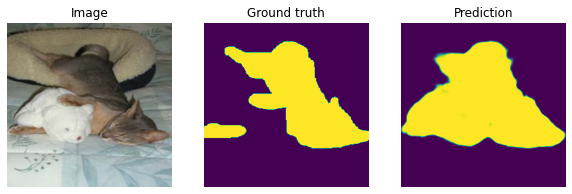

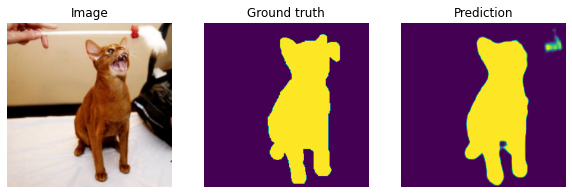

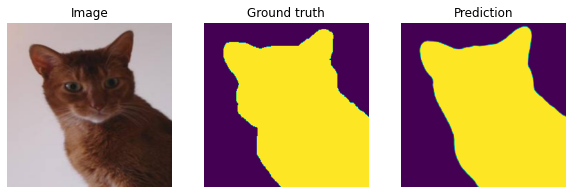

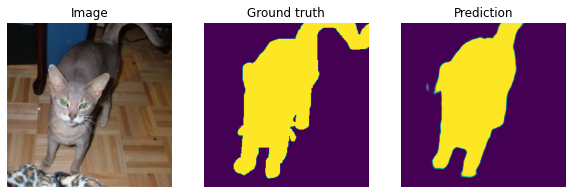

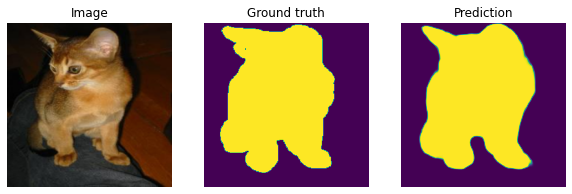

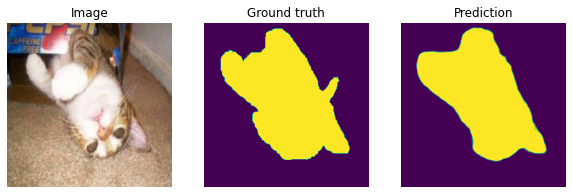

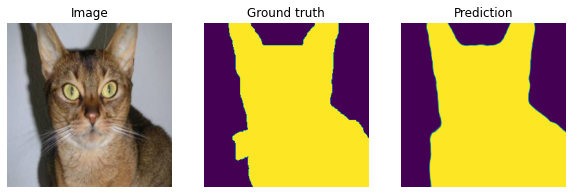

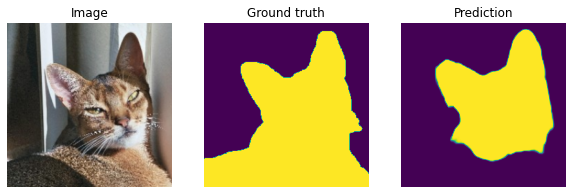

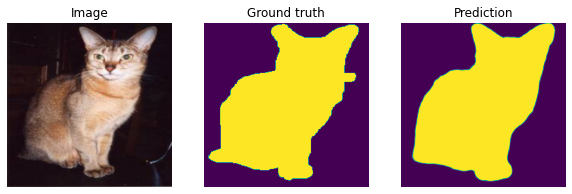

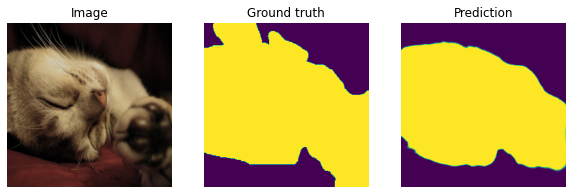

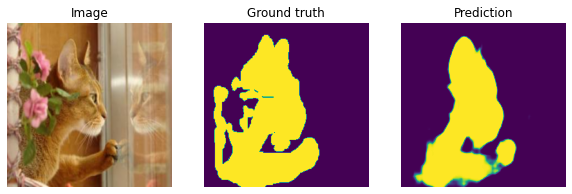

In [12]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"].cuda())
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    # just squeeze classes dim, because we have only one class
    plt.imshow(gt_mask.numpy().squeeze())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    # just squeeze classes dim, because we have only one class
    plt.imshow(pr_mask.cpu().numpy().squeeze())
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [13]:
torch.save(model.state_dict(), "model.pt")